In [2]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Polygon,Point
import numpy as np

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((24.7828 60.09996, 24.81697 60.06209,...",24.782803,59.922486,25.254512,60.29785,155619266,relation,34914,60.167488,24.942747,boundary,administrative,15,0.785427,city,Helsinki,"Helsinki, Helsinki sub-region, Uusimaa, Mainla..."


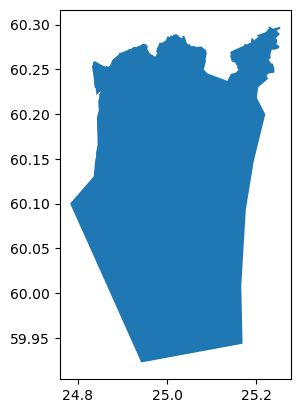

In [ ]:
#getting city data. Eg. Helsinki

#download city boundary
city = ox.geocode_to_gdf("Helsinki, Finland")

city.plot()
city
#city.to_file("../data/helsinki.geojson", driver="GeoJSON")
#city.to_file("../data/kuopio.geojson", driver="GeoJSON")

<Axes: >

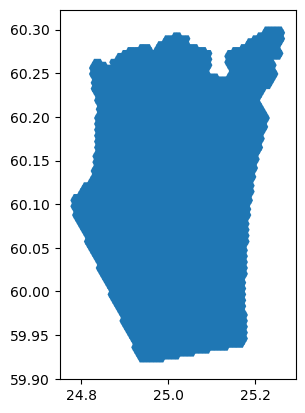

In [ ]:
#generate a hex grid over the city

def generate_hex_grid(geometry, hex_size_m):
    #converting hex size to degree (approximate for small regions)
    hex_height = hex_size_m / 111320 # 1deg = 11.32km
    hex_width = hex_height * np.sqrt(3) 

    bounds = geometry.total_bounds #xmin, ymin, xmax, ymax
    xmin, ymin, xmax, ymax = bounds #unpacking tuple

    hexes = []
    y = ymin #start at the bottom of the y axis
    row = 0 
    
    while y < ymax + hex_height:

        x = xmin + (hex_width / 2 if row % 2 else 0)
        while x < xmax + hex_width:
            
            hex_center = (x, y) 

            hex_poly = Polygon([
                (x + hex_width * np.cos(np.radians(angle)), y + hex_height * np.sin(np.radians(angle)))
                
                for angle in range(0, 360, 60) 
            ])
            if hex_poly.intersects(geometry.union_all()):
                hexes.append(hex_poly)
            x += hex_width 
        y += hex_height * 3/4 #vertical
        row += 1 
        
    return gpd.GeoDataFrame(geometry=hexes, crs=geometry.crs) 

#generate grid. 500m hexes
hex_grid = generate_hex_grid(city, hex_size_m=500)

hex_grid.plot()

<Axes: >

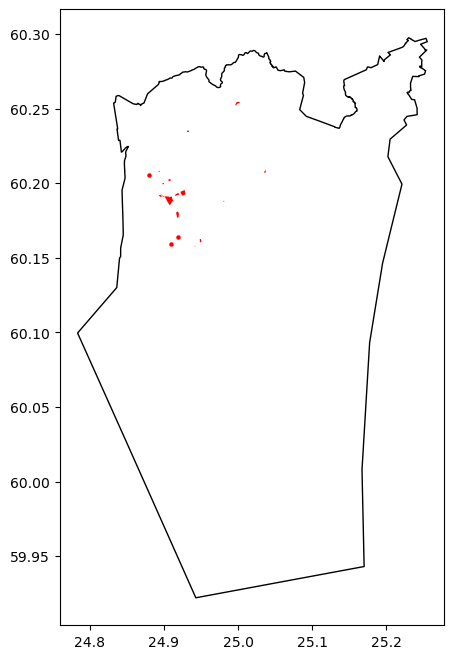

In [67]:
#get hospitals in the city
#needs city name. the city variable in the earlier code doesnt return a name but a table
hospitals = ox.features_from_place("Helsinki, Finland", tags={"amenity": "hospital"})

#keep only points or centroids
hospitals = hospitals[~hospitals.geometry.is_empty].to_crs(hex_grid.crs)

#visualize on top of the city boundary
ax = city.plot(color='white', edgecolor='black', figsize=(6, 8))
hospitals.plot(ax=ax, color='red', markersize=5)

In [ ]:

hex_grid['centroid'] = hex_grid.geometry.centroid

C:\Users\aduko\AppData\Local\Temp\ipykernel_3764\1650527207.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_grid['centroid'] = hex_grid.geometry.centroid


In [ ]:


from shapely.ops import nearest_points

#combine all hospital geomtries into one searchable structure
hospital_union = hospitals.geometry.union_all()

def get_nearest_distance(point, hospital_union):
    nearest = nearest_points(point, hospital_union)[1]
    return point.distance(nearest)

#apply it to each hex
hex_grid['dist_to_hospital_deg'] = hex_grid['centroid'].apply(lambda pt: get_nearest_distance(pt, hospital_union))

#convert from deg to m
hex_grid['dist_to_hospital_m'] = hex_grid['dist_to_hospital_deg'] * 111_320

<Axes: >

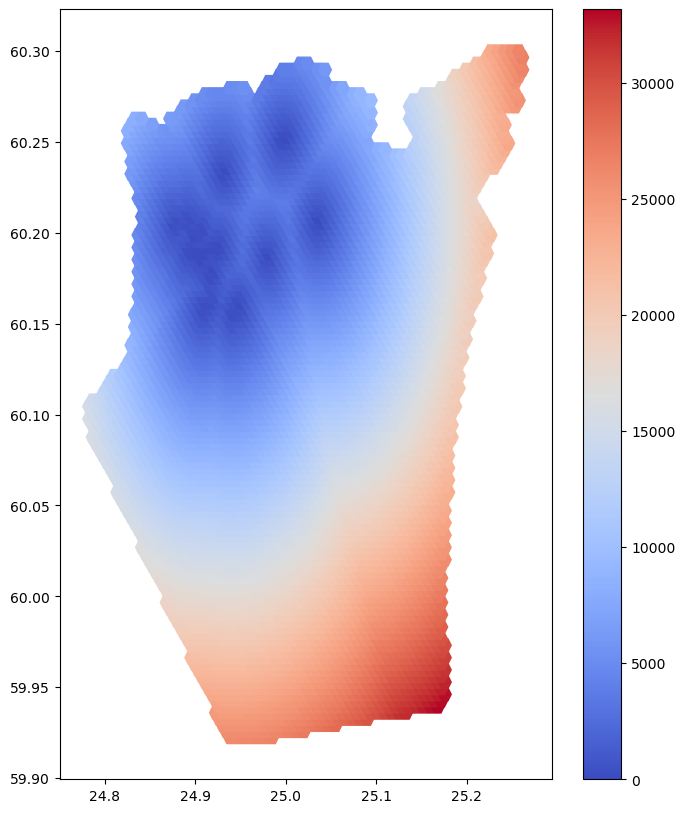

In [ ]:

hex_grid.plot(column='dist_to_hospital_m', cmap='coolwarm', legend=True, figsize=(8, 10))


In [79]:
#save result as geopackage
hex_grid.drop(columns='centroid').to_file("../data/processed/hex_gridgpkg.gpkg", driver="GPKG")

In [81]:
#save as parquet for ML pipelines
#Parquet is a file format used to store tabular data (like rows and columns in a spreadsheet or DataFrame).
hex_grid.to_parquet("../data/processed/hex_grid.parquet")